# ML Lec 08 - Neural Network 1: XOR 문제와 학습방법, Backpropagation

## 참조 강의: 

- [lab9-1: XOR을 위한 텐스플로우 딥넷트웍](https://youtu.be/9i7FBbcZPMA)
- [lab9-2: Tensor Board로 딥네트웍 들여다보기](https://youtu.be/eDKxY5Z5dVQ)

## 작업내용:

강의 내용을 응용해서 데이터셋은 mnist example 을 이용한다. multinomial 예제와 다른 부분은 가설함수와 cost 함수가 달라졌다. 그리고 tensorboard를 통해서 노드의 값을 추적해 본다. 여기서는 정확도 개선작업은 주목적이 아니기 때문에 생략한다.



In [1]:
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# anaconda에 설치된 tensorflow 예제 mnist example에 대한 경로명을 추가한다.
import sys
sys.path.insert(1, '/root/anaconda2/lib/python2.7/site-packages/tensorflow/examples/tutorials/mnist')



Populating the interactive namespace from numpy and matplotlib


In [2]:
## Part 1: 이미지 데이터 로드
# -----------------------------
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print mnist.train.labels[0:5, :]

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [4]:
## Part 2: 변수, 가설함수, cost function 및 gradient descent 정의
# ----------------------------------------------------------------
# 변수 선언
X = tf.placeholder(tf.float32, [None, 784], name="inputX") # bias term 제외, 하나의 이미지는 28x28이다.
Y = tf.placeholder(tf.float32, [None, 10], name="inputY") # one-hot encoding 때문에 10개로 선언한다.

# 모델의 파라미터 선언
W1 = tf.Variable(tf.random_uniform([784, 10], -1.0, 1.0), name="Weight1")
W2 = tf.Variable(tf.random_uniform([10, 10], -1.0, 1.0), name="Weight2")
b1 = tf.Variable(tf.random_uniform([10], -1.0, 1.0), name="Bias1")
b2 = tf.Variable(tf.random_uniform([10], -1.0, 1.0), name="Bias2")


# 가설함수 정의
# 더 좋은 graph hierch를 가지기 위해서 scope를 정의한다.
with tf.name_scope("ScopeLayer2") as scope: # tensorboard step 1: annotate하고자 하는 node 선택
    L2 = tf.sigmoid(tf.matmul(X, W1) + b1)

with tf.name_scope("ScopeLayer3") as scope:
    hypothesis = tf.sigmoid(tf.matmul(L2, W2) + b2)


# cost function 정의
with tf.name_scope("ScopeCost") as scope:
    cost = -tf.reduce_mean(Y*tf.log(hypothesis) + (1-Y)*tf.log(1-hypothesis))
    # scalar 변수는 tf.scalar_summary를 사용한다.
    cost_summ = tf.scalar_summary("cost_summ", cost)

# tensorboard step 1: histogram 추가
w1_hist = tf.histogram_summary("w1_hist", W1)
w2_hist = tf.histogram_summary("w2_hist", W2)
b1_hist = tf.histogram_summary("b1_hist", b1)
b2_hist = tf.histogram_summary("b2_hist", b2)
y_hist = tf.histogram_summary("y_hist", Y)

# gradient descent를 위한 optimize 정의
with tf.name_scope("train") as scope:
    learning_rate = tf.Variable(1.0)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(cost)


Epoch: 0001 , cost =  0.281199475 
Epoch: 0003 , cost =  0.166136263 
Epoch: 0005 , cost =  0.128846994 
Epoch: 0007 , cost =  0.110022618 
Epoch: 0009 , cost =  0.098825299 
Epoch: 0011 , cost =  0.091759281 
Epoch: 0013 , cost =  0.086721163 
Epoch: 0015 , cost =  0.082864301 
Epoch: 0017 , cost =  0.079718545 
Epoch: 0019 , cost =  0.077006722 
Optimizaiton finishied.


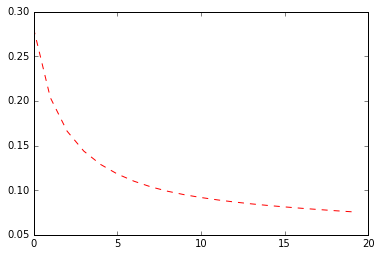

In [5]:
## Part 3: training dataset
# batch로 트레이닝한다.
# ------------------------------

#tf.reset_default_graph()

# tensorboard step 2: 모든 summary를 통합한다.
merged = tf.merge_all_summaries()
#merged = tf.merge_summary([w1_hist, w2_hist, b1_hist, b2_hist, y_hist])


# 변수 초기화 및 그래프 시작
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# tensorboard step 3: writer를 생성한다.
writer = tf.train.SummaryWriter("./logs/test", sess.graph_def)


# Using small batches of random data is called stochastic training
# 작은 배치 사이즈로 트레이닝한다. 이것은 stochastic training이라고도 한다.
# 전체 데이터로 하면 정확도가 높긴하지만, 비용이 많이 든다. 

# 아래 변수들을 적당히 조정해야 한다.
training_epochs = 20 # 전체 트레이닝 반복 횟수 20
batch_size = 100 # 한 번에 처리하는 데이터 사이즈 100
display_step = 2 # progress 표시 
arr_J = np.zeros(training_epochs) # cost 저장

# training 반복횟수만큼 루프실행
for epoch in range(training_epochs):
    avg_cost = 0;
    total_batch = int(mnist.train.num_examples / batch_size)
    
    # 전체 배치 수를 결정하고 각 배치에 대해서 루프를 실행한다.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(train, feed_dict={X: batch_xs, Y: batch_ys})
    
        # cost를 계산한다.
        avg_cost += sess.run(cost, feed_dict = {X: batch_xs, Y: batch_ys}) / total_batch

    # tensorboard step 4: merged와 add_summary를 실행한다.
    summary = sess.run(merged, feed_dict={X: batch_xs, Y: batch_ys}) # placehoder관련 오류 발생        
    writer.add_summary(summary, epoch)
    
    if epoch % display_step == 0:
        print "Epoch: %04d" % (epoch + 1), ", cost = ", "{:.9f} ".format(avg_cost)
    
    # cost를 plot한다.
    arr_J[epoch] = avg_cost

print "Optimizaiton finishied."
plot(arr_J, 'r--')




Label:  [9]
Prediction:  [9]


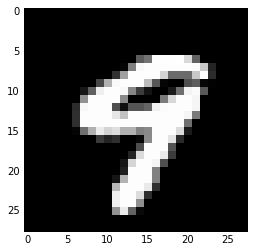

Accuracy:  88.5800004005


In [6]:
## Part 4: Predict & Show
# test set에서 임의로 하나의 이미지를 선택하고 예측한다.
# -----------------------------------------------------
# image를 보여준다.
r = randint(0, mnist.test.num_examples - 1)
# XXX: labels[r:r+1] 은 2차원 배열(행렬)로 반환한다. labels[r]은 1차원 벡터를 반환한다.
print "Label: ", sess.run(tf.argmax(mnist.test.labels[r:r+1], 1))
print "Prediction: ", sess.run(tf.argmax(hypothesis, 1), feed_dict = {X: mnist.test.images[r:r+1]})

# 이미지 출력
#plt.set_cmap('gray')
plt.imshow(mnist.test.images[r:r+1].reshape(28, 28), cmap="gray", interpolation="nearest")
plt.show()



## Part 4: test set에 대한 모델의 정확도를 계산한다.
# -----------------------------------------------------

# Test 모델 구축
# activation은 모델이 예측한 값을 가지고 있고, Y는 실제 label의 값이다.
# tf.argmax() 함수는 임의의 축(가로 또는 세로)에 대한 가장 높은 값을 갖는 인덱스를 반환한다.
correct_prediction = tf.equal(tf.argmax(hypothesis,1), tf.argmax(Y,1))
# correct_prediction은 [True, False]와 같은 boolean 값을 갖는다. float으로 형변환 하면
# 1, 0 으로 바뀌게 되고 평균을 취한다.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 정확도를 계산한다.
print "Accuracy: ", sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}) * 100
#print "Accuracy: ", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels})

